In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'svg'
config = {'font.family': 'Times New Roman',
          'font.size': 15,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'mathtext.fontset': 'stix',
         }
plt.rcParams.update(config)

zimu = "B"
nlay = 50
ncol = 200

cishu = 60*5

results = np.load(f"./output/{zimu}/results.npy").reshape(cishu+1, 10, nlay, ncol) # 时刻 种类
n = np.load(f"./output/{zimu}/results_porosity.npy").reshape(cishu+1, nlay, ncol)
K = np.load(f"./output/{zimu}/results_K.npy").reshape(cishu+1, nlay, ncol)
K_log = np.log(K)

print(results.shape)
print(n.shape)
print(K.shape)
# print(heads.shape)

# ['0 K' '1 Na' '2 Ca' '3 Mg' '4 Li' '5 Cl' '6 S(6)' '7 C(4)' '8 Halite'
#  '9 Carnallite' '10 Polyhalite' '11 Sylvite' '12 Gypsum' '13 Calcite' '14 Dolomite'
#  '15 d_Halite' '16 d_Carnallite' '17 d_Polyhalite' '18 d_Sylvite' '19 d_Gypsum' '20 d_Calcite' '21 d_Dolomite'
#  '22 density(kg/m3)'
#  '23 SI_Halite' '24 SI_Carnallite' '25 SI_Polyhalite' '26 SI_Sylvite' '27 SI_Gypsum' '28 SI_Calcite' '29 SI_Dolomite']

(301, 10, 50, 200)
(301, 50, 200)
(301, 50, 200)


In [2]:
int(cishu/30)

10

0.00010015645474355239
8307.191378026237


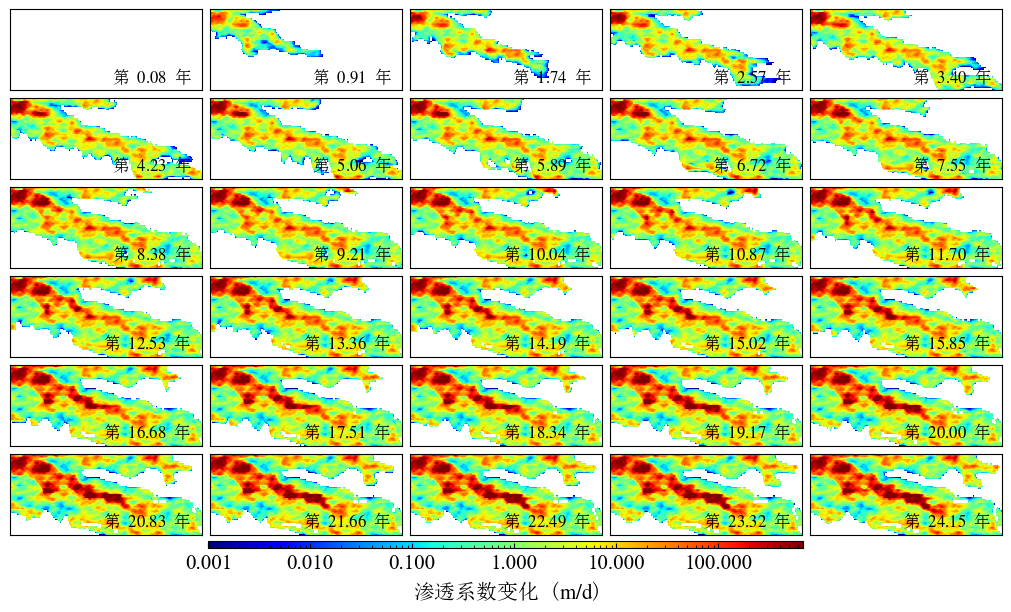

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

data_to_plot_percent = [(K[i, :, :]-K[0, :, :]) for i in range(1, cishu+1, int(cishu/30))] # -K[0, :, :]

data_to_plot_log = []
for arr_percent in data_to_plot_percent:
    mask = (arr_percent <= 0) | (arr_percent < 1e-4)
    masked_arr = np.ma.array(arr_percent, mask=mask)
    data_to_plot_log.append(masked_arr)

all_positive_values = np.concatenate([arr.compressed() for arr in data_to_plot_log])

if len(all_positive_values) > 0:
    log_vmin = np.min(all_positive_values)
    log_vmax = np.max(all_positive_values)
    if log_vmin < 1e-4:
        log_vmin = 1e-4
else:
    log_vmin = 1e-4
    log_vmax = 1.0

if log_vmin >= log_vmax:
    log_vmax = log_vmin * 10
print(log_vmin)
print(log_vmax)
log_vmin = 0.001
log_vmax = 684
n_rows, n_cols = 6, 5
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(10, 6),
    constrained_layout=True    # <— 打开 constrained_layout
)
axes = axes.flatten()
time_points = list(range(1, cishu+1, int(cishu/30)))

for idx, arr_log in enumerate(data_to_plot_log):
    ax = axes[idx]
    norm = LogNorm(vmin=log_vmin, vmax=log_vmax)
    mappable = ax.imshow(arr_log, cmap="jet", norm=norm, aspect='auto')
    # ax.set_title(f'K[{idx*2+1}] - K[0] (%)')
    ax.set_xticks([])
    ax.set_yticks([])

    # 计算当前时刻对应的年
    t = time_points[idx]
    year = t * 0.083

    ax.text(
        0.95, 0.05,
        f'第 ${year:.2f}$ 年',
        transform=ax.transAxes,
        fontdict={'family': 'SimSun'},
        ha='right', va='bottom',
        fontsize=12,
        # color='white',
    )

for ax in axes[len(data_to_plot_log):]:
    fig.delaxes(ax)

cbar = fig.colorbar(
    mappable,
    ax=axes[:len(data_to_plot_log)].tolist(),
    location='bottom',
    pad=0.01,
    aspect=80,
    format='%.3f',
    shrink=0.6
)
cbar.set_label(r'渗透系数变化 ($\mathrm{m/d}$)', fontdict={'family': 'SimSun'})
plt.show()

In [4]:
"""
preferential_channel_metrics.py

输入:
  K: numpy array shape (nt, ny, nx)  # 对应你的 (31,100,400)
输出:
  results.csv with metrics for each time step
依赖: numpy, scipy, skimage, pandas
"""

import numpy as np
from scipy import ndimage
from skimage.morphology import skeletonize
from skimage.filters import threshold_otsu
from scipy.ndimage import distance_transform_edt
import pandas as pd

def gini(arr):
    """Gini coefficient for 1D non-negative array"""
    a = np.asarray(arr).flatten()
    a = a[~np.isnan(a)]
    a = a[a >= 0]
    if a.size == 0:
        return 0.0
    a = np.sort(a)
    n = a.size
    index = np.arange(1, n+1)
    return (2.0 * np.sum(index * a) / (n * np.sum(a))) - (n + 1.0)/n

def remove_small_objects(mask, min_size=8, connectivity=2):
    labels, n = ndimage.label(mask, structure=ndimage.generate_binary_structure(2, connectivity))
    if n == 0:
        return mask
    counts = np.bincount(labels.ravel())
    # counts[0] is background
    remove_labels = np.where(counts < min_size)[0]
    out = mask.copy()
    for lab in remove_labels:
        if lab == 0:
            continue
        out[labels == lab] = False
    return out

def is_percolating(labels):
    """labels: integer labeled array of channel_mask (0 background).
       Checks if any label touches both left and right boundaries."""
    if labels.max() == 0:
        return False, None
    left = labels[:, 0]
    right = labels[:, -1]
    left_ids = np.unique(left[left > 0])
    right_ids = np.unique(right[right > 0])
    common = np.intersect1d(left_ids, right_ids)
    if common.size > 0:
        return True, int(common[0])
    else:
        return False, None

def compute_metrics_for_snapshot(K2d,
                                 mask_domain=None,
                                 percentile=90,
                                 min_area=8,
                                 connectivity=2):
    """
    K2d: 2D array (ny, nx)
    Returns dict of metrics for this snapshot
    """
    ny, nx = K2d.shape
    if mask_domain is None:
        mask_domain = np.ones_like(K2d, dtype=bool)
    # handle nonpositive or nan K
    Kwork = K2d.copy().astype(float)
    Kwork[~mask_domain] = np.nan
    # safe log
    with np.errstate(divide='ignore', invalid='ignore'):
        logk = np.log10(Kwork)
    # choose threshold by percentile or Otsu if percentile is None
    if percentile is None:
        # Otsu requires finite values
        vals = logk[np.isfinite(logk)]
        if vals.size == 0:
            thresh = np.nan
        else:
            thresh = threshold_otsu(vals)
    else:
        thresh = np.nanpercentile(logk, percentile)
    channel_mask = (logk >= thresh) & mask_domain & np.isfinite(logk)
    # remove small objects
    channel_mask = remove_small_objects(channel_mask, min_size=min_area, connectivity=connectivity)
    # label
    struct = ndimage.generate_binary_structure(2, connectivity)
    labels, nlab = ndimage.label(channel_mask, structure=struct)
    # metrics
    domain_area = mask_domain.sum()
    AF = channel_mask.sum() / float(domain_area) if domain_area>0 else np.nan
    areas = np.bincount(labels.ravel())[1:] if nlab>0 else np.array([0])
    A_max = areas.max() if areas.size>0 else 0
    A_max_frac = A_max / float(domain_area) if domain_area>0 else np.nan
    # percolation (left->right)
    perco, perco_label = is_percolating(labels)
    # skeleton + width
    try:
        skel = skeletonize(channel_mask)
        if skel.sum() > 0:
            dt = distance_transform_edt(~channel_mask)  # distance to background
            widths = 2.0 * dt[skel]  # local widths in grid units
            mean_width = float(np.mean(widths))
            median_width = float(np.median(widths))
            finger_count = int(np.sum((skel) & (ndimage.convolve(skel.astype(int), np.ones((3,3)), mode='constant')==2)))
        else:
            mean_width = 0.0
            median_width = 0.0
            finger_count = 0
    except Exception:
        mean_width = np.nan
        median_width = np.nan
        finger_count = 0

    # Gini on K restricted to mask_domain (use K values as proxy for 'capacity')
    k_vals = Kwork[mask_domain]
    k_vals = k_vals[np.isfinite(k_vals) & (k_vals >= 0)]
    gini_k = gini(k_vals) if k_vals.size>0 else np.nan

    # log-k moments
    logk_vals = logk[mask_domain]
    logk_vals = logk_vals[np.isfinite(logk_vals)]
    if logk_vals.size > 0:
        logk_mean = float(np.mean(logk_vals))
        logk_std = float(np.std(logk_vals))
    else:
        logk_mean = np.nan; logk_std = np.nan

    # anisotropy: PCA on coordinates of channel pixels
    coords = np.column_stack(np.nonzero(channel_mask))
    anisotropy = np.nan
    if coords.shape[0] >= 3:
        cov = np.cov(coords.T)
        eigvals = np.linalg.eigvalsh(cov)
        eigvals = np.sort(eigvals)[::-1]
        if eigvals[1] > 0:
            anisotropy = float(eigvals[0] / eigvals[1])
        else:
            anisotropy = np.nan

    return {
        'AF': AF,
        'A_max_frac': A_max_frac,
        'percolating': bool(perco),
        'percolating_label': perco_label if perco else -1,
        'mean_width_px': mean_width,
        'median_width_px': median_width,
        'finger_count': finger_count,
        'gini_k': gini_k,
        'logk_mean': logk_mean,
        'logk_std': logk_std,
        'anisotropy_ratio': anisotropy,
        'n_labels': int(nlab)
    }

def run_time_series(K3d, percentile=90, min_area=8, connectivity=2, mask_domain=None, out_csv='results.csv'):
    """
    K3d: (nt, ny, nx)
    returns pandas DataFrame and writes csv
    """
    nt, ny, nx = K3d.shape
    results = []
    for t in range(nt):
        metrics = compute_metrics_for_snapshot(K3d[t,:,:], mask_domain=mask_domain,
                                               percentile=percentile,
                                               min_area=min_area,
                                               connectivity=connectivity)
        metrics['time_index'] = t
        results.append(metrics)
    df = pd.DataFrame(results)
    # reorder columns
    cols = ['time_index','percolating','A_max_frac','AF','mean_width_px','median_width_px',
            'finger_count','gini_k','logk_mean','logk_std','anisotropy_ratio','n_labels','percolating_label']
    cols = [c for c in cols if c in df.columns]
    df = df[cols]
    df.to_csv(out_csv, index=False)
    return df

# Example usage:
# import numpy as np
# K = np.load('K_31_100_400.npy')  # shape (31,100,400)
df = run_time_series(K, percentile=90, min_area=12,)
# print(df.head())


   time_index    gini_k  n_labels  finger_count           PCI
0           0  0.748220        23            59  0.000000e+00
1           1  0.748220        23            59  1.371804e-16
2           2  0.753351        21            50  6.454425e-02
3           3  0.756281        21            52  5.890136e-02
4           4  0.762579        21            51  6.790170e-02


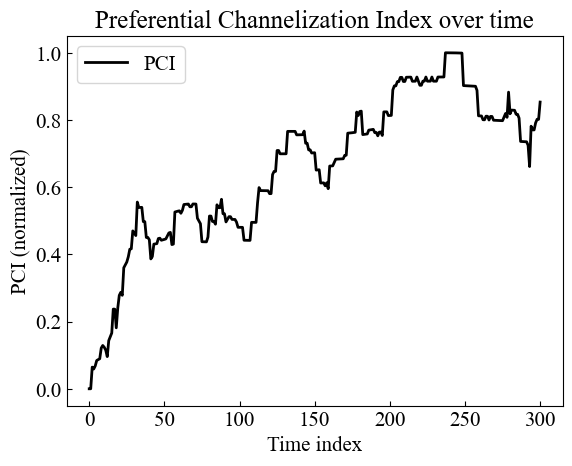

In [5]:
import pandas as pd
import numpy as np

def compute_PCI(df, alpha=0.05, beta=0.01, gamma=1.0, eta=1.0, zeta=1.0, normalize=True):
    """
    计算优势通道指数 PCI (Preferential Channelization Index)
    参数：
        df: DataFrame，必须包含列 ['gini_k', 'n_labels', 'finger_count']
        alpha, beta: 权重参数，控制 n_labels 和 finger_count 的惩罚强度
        gamma, eta, zeta: 幂指数，用于调节非线性影响
        normalize: 是否将结果归一化到 [0,1]
    返回：
        df: 在原始 df 基础上添加一列 'PCI'
    """
    gini = df['gini_k'].clip(lower=1e-6)
    nlab = df['n_labels'].clip(lower=1)
    fing = df['finger_count'].clip(lower=1)
    
    PCI = (gini ** gamma) / ((1 + alpha * nlab) ** eta * (1 + beta * fing) ** zeta)
    
    if normalize:
        # 归一化到 [0,1] 方便比较
        PCI = (PCI - PCI.min()) / (PCI.max() - PCI.min() + 1e-9)
    
    df['PCI'] = PCI
    return df

df = compute_PCI(df)

# 查看前几行结果
print(df[['time_index', 'gini_k', 'n_labels', 'finger_count', 'PCI']].head())

# 绘制时间演化
import matplotlib.pyplot as plt
plt.plot(df['time_index'], df['PCI'], 'k-', lw=2, label='PCI')
plt.xlabel('Time index')
plt.ylabel('PCI (normalized)')
plt.title('Preferential Channelization Index over time')
plt.legend()
plt.show()

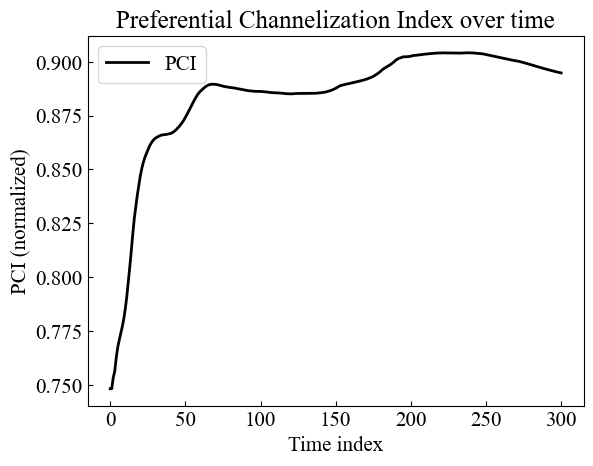

In [6]:
import matplotlib.pyplot as plt
plt.plot(df['time_index'], df['gini_k'], 'k-', lw=2, label='PCI')
plt.xlabel('Time index')
plt.ylabel('PCI (normalized)')
plt.title('Preferential Channelization Index over time')
plt.legend()
plt.show()

In [7]:
data_to_plot_percent = np.array(data_to_plot_percent).reshape(30, 400)
data_to_plot_percent.mean(1).shape

ValueError: cannot reshape array of size 300000 into shape (30,400)

In [ ]:
data_to_plot_percent.shape

In [ ]:
plt.plot(data_to_plot_percent[:, 398])
plt.plot(data_to_plot_percent[:, 90])
plt.plot(data_to_plot_percent[:, 190])
plt.plot(data_to_plot_percent[:, 298])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

data_to_plot_percent = [n[i, :, :] for i in range(1, cishu+1, 2)] #  - n[0, :, :]) / n[0, :, :] * 100

data_to_plot_log = []
for arr_percent in data_to_plot_percent:
    mask = (arr_percent <= 0) | (arr_percent < 1e-4)
    masked_arr = np.ma.array(arr_percent, mask=mask)
    data_to_plot_log.append(masked_arr)

all_positive_values = np.concatenate([arr.compressed() for arr in data_to_plot_log])

if len(all_positive_values) > 0:
    log_vmin = np.min(all_positive_values)
    log_vmax = np.max(all_positive_values)
    if log_vmin < 1e-4:
        log_vmin = 1e-4
else:
    log_vmin = 1e-4
    log_vmax = 1.0

if log_vmin >= log_vmax:
    log_vmax = log_vmin * 10
print(log_vmin)
print(log_vmax)
log_vmin = 0.29
log_vmax = 0.65
n_rows, n_cols = 6, 5
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(10, 6),
    constrained_layout=True    # <— 打开 constrained_layout
)
axes = axes.flatten()
time_points = list(range(1, 61, 2))

for idx, arr_log in enumerate(data_to_plot_log):
    ax = axes[idx]
    norm = LogNorm(vmin=log_vmin, vmax=log_vmax)
    mappable = ax.imshow(arr_log, cmap="jet", aspect='auto') # norm=norm, 
    # ax.set_title(f'K[{idx*2+1}] - K[0] (%)')
    ax.set_xticks([])
    ax.set_yticks([])

    # 计算当前时刻对应的年
    t = time_points[idx]
    year = t * 0.083

    ax.text(
        0.95, 0.05,
        f'第 ${year:.2f}$ 年',
        transform=ax.transAxes,
        fontdict={'family': 'SimSun'},
        ha='right', va='bottom',
        fontsize=12,
        # color='white',
    )

for ax in axes[len(data_to_plot_log):]:
    fig.delaxes(ax)

cbar = fig.colorbar(
    mappable,
    ax=axes[:len(data_to_plot_log)].tolist(),
    location='bottom',
    pad=0.01,
    aspect=80,
    format='%.3f',
    shrink=0.6
)

cbar.set_label(r'孔隙度变化比率 ($\mathrm{\%}$)', fontdict={'family': 'SimSun'})

plt.show()

In [ ]:
n[-1]

In [ ]:
data_to_plot_percent = np.array(data_to_plot_percent).reshape(30, 40000)
data_to_plot_percent.mean(1).shape

In [ ]:
time_steps = K.shape[0]
mean_values = [np.mean(K[i, :, :]) for i in range(time_steps)]

time_years = np.arange(time_steps) * 0.083

plt.figure(figsize=(11,2))
plt.plot(time_years, 
         mean_values, 
         marker='o', 
         linewidth=2,
         color='#b86366', 
         markersize=6, 
         markeredgecolor='black', 
         linestyle='-',
)
plt.yticks([2.0, 2.5, 3.0, 3.5])
plt.xlabel("时间 (年)", fontdict={'family': 'SimSun', 'size': 12})
plt.ylabel(r"平均渗透系数 ($\mathrm{m/d}$)", fontdict={'family': 'SimSun', 'size': 12})

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
time_steps = n.shape[0]
mean_values = [np.mean(n[i, :, :]) for i in range(time_steps)]

time_years = np.arange(time_steps) * 0.083

plt.figure(figsize=(11,2))
plt.plot(time_years, 
         mean_values, 
         marker='o', 
         linewidth=2,
         color='#4e9381', 
         markersize=6, 
         markeredgecolor='black', 
         linestyle='-',
)
plt.yticks([0.30, 0.31, 0.32, 0.33])
plt.xlabel("时间 (年)", fontdict={'family': 'SimSun', 'size': 12})
plt.ylabel(r"平均渗透系数 ($\mathrm{m/d}$)", fontdict={'family': 'SimSun', 'size': 12})

plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
